### Dataset
Best Artworks of all time - 
https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time


In [1]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od
import shutil
import os
import random
od.download('https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time', force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading best-artworks-of-all-time.zip to ./best-artworks-of-all-time


100%|██████████| 2.29G/2.29G [02:01<00:00, 20.2MB/s]


In [4]:
shutil.rmtree('best-artworks-of-all-time/resized')

In [5]:
list_ = os.listdir('best-artworks-of-all-time/images/images/')
rand_list = random.sample(list_, 40)
for item in rand_list:
  shutil.rmtree(os.path.join('best-artworks-of-all-time/images/images/', item))

In [6]:
data_path = 'best-artworks-of-all-time/images/images'

In [7]:
import torch
from torchvision import datasets, transforms

In [8]:
## Device agnostic code

device = 'cuda'
device 

'cuda'

In [9]:
# train_transform = transforms.Compose([
#     torch.Resize(64, 64),
#     torch.RandomCrop(64),
#     transforms.TrivialAugmentWide(num_magnitude_bins=31),
#     transforms.ToTensor()
# ])

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [10]:
data = datasets.ImageFolder(root = data_path, 
                            transform = data_transform)

In [11]:
val_size = int(0.2*len(data))
train_size = len(data) - val_size

train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, val_size])

In [12]:
len(train_dataset), len(test_dataset)

(1810, 452)

Text(0.5, 1.0, 'Gustave_Courbet')

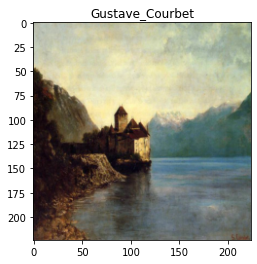

In [13]:
# Sample image
import matplotlib.pyplot as plt
import random
r_idx = random.choice(range(len(train_dataset)))
img, label = train_dataset[r_idx]
plt.imshow(img.permute(1, 2, 0))
plt.title(data.classes[label])

In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE
)

(-0.5, 223.5, 223.5, -0.5)

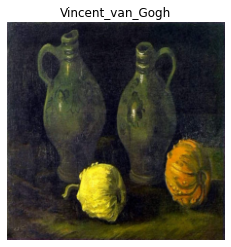

In [15]:
batch, labels = next(iter(train_dataloader))
img, label = batch[15], labels[15]
plt.imshow(img.permute(1, 2, 0))
plt.title(f'{data.classes[label]}')
plt.axis(False)

In [16]:
class_names = data.classes

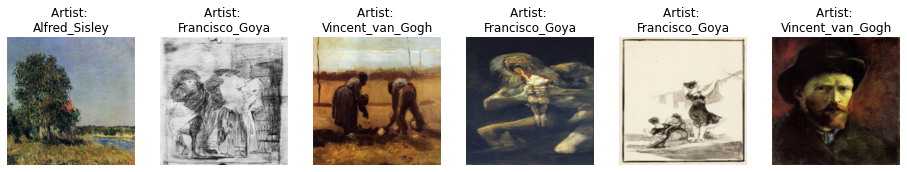

In [17]:
random_samples_idx = random.sample(range(len(train_dataset)), k=6)

# 5. Setup plot
plt.figure(figsize=(16, 8))

# 6. Loop through samples and display random samples 
for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = train_dataset[targ_sample][0], train_dataset[targ_sample][1]

    # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, 6, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    title = f"Artist: \n{class_names[targ_label]}"
    plt.title(title)

In [18]:
from torchvision.models import resnet50, ResNet50_Weights
from torch import nn
model1 = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
for param in model1.parameters():
    param.requires_grad = False   
    
model1.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, len(class_names))).to(device)

In [19]:
!pip install torchinfo
from torchinfo import summary
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model1, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 11]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [ ]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model1.parameters(), lr = 0.01)

In [21]:
try:
  from torchmetrics.classification import MulticlassAccuracy as accuracy_fn
except:
  !pip install torchmetrics
  from torchmetrics.classification import MulticlassAccuracy as accuracy_fn

In [22]:
def train_step(model : nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn : nn.Module,
               optimizer : torch.optim.Optimizer):
     # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
  
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [23]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int):

  results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []
  }
  for epoch in tqdm(range(epochs)):
          
          train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer)
          test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

          # Print out what's happening
          print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
          )

          # Update results dictionary
          results["train_loss"].append(train_loss)
          results["train_acc"].append(train_acc)
          results["test_loss"].append(test_loss)
          results["test_acc"].append(test_acc)

      # Return the filled results at the end of the epochs
  return results

In [24]:
results = train(model1, train_dataloader, test_dataloader, optimizer, loss_fn, 30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2377 | train_acc: 0.3379 | test_loss: 2.0935 | test_acc: 0.3792
Epoch: 2 | train_loss: 1.9623 | train_acc: 0.3913 | test_loss: 1.9000 | test_acc: 0.3792
Epoch: 3 | train_loss: 1.8052 | train_acc: 0.3925 | test_loss: 1.7865 | test_acc: 0.3792
Epoch: 4 | train_loss: 1.6818 | train_acc: 0.4031 | test_loss: 1.6602 | test_acc: 0.4292
Epoch: 5 | train_loss: 1.5626 | train_acc: 0.4690 | test_loss: 1.5552 | test_acc: 0.5062
Epoch: 6 | train_loss: 1.4545 | train_acc: 0.5330 | test_loss: 1.4746 | test_acc: 0.5271
Epoch: 7 | train_loss: 1.3576 | train_acc: 0.5752 | test_loss: 1.3629 | test_acc: 0.5854
Epoch: 8 | train_loss: 1.2647 | train_acc: 0.6318 | test_loss: 1.2826 | test_acc: 0.6229
Epoch: 9 | train_loss: 1.1995 | train_acc: 0.6618 | test_loss: 1.2128 | test_acc: 0.6438
Epoch: 10 | train_loss: 1.1270 | train_acc: 0.6912 | test_loss: 1.1433 | test_acc: 0.6708
Epoch: 11 | train_loss: 1.0552 | train_acc: 0.7072 | test_loss: 1.0758 | test_acc: 0.6937
Epoch: 12 | train_l

{'train_loss': [2.237669030825297,
  1.9623386190648664,
  1.8052370129970081,
  1.681784479241622,
  1.56260697674333,
  1.4544580777486165,
  1.3576159979167737,
  1.2646918892860413,
  1.1995126740974293,
  1.1270037251606322,
  1.0552027581030863,
  1.003322790589249,
  0.9582690450183132,
  0.9067934563285426,
  0.8564892568086323,
  0.8206497744510048,
  0.7821253945952967,
  0.7559751162403509,
  0.7182578627477613,
  0.6906863890196148,
  0.6681874153906839,
  0.6480023735447934,
  0.6252961200580263,
  0.6080341302511985,
  0.5825117507524658,
  0.5602554373050991,
  0.5460475369503623,
  0.5379700143086282,
  0.5142221534461305,
  0.5003255354730707],
 'train_acc': [0.33790204678362573,
  0.3912646198830409,
  0.3925438596491228,
  0.4031432748538012,
  0.46899366471734893,
  0.5329556530214424,
  0.5751705653021443,
  0.6317616959064327,
  0.661793372319688,
  0.6912158869395711,
  0.7071759259259259,
  0.7259381091617934,
  0.7269736842105263,
  0.7433601364522417,
  0.7486

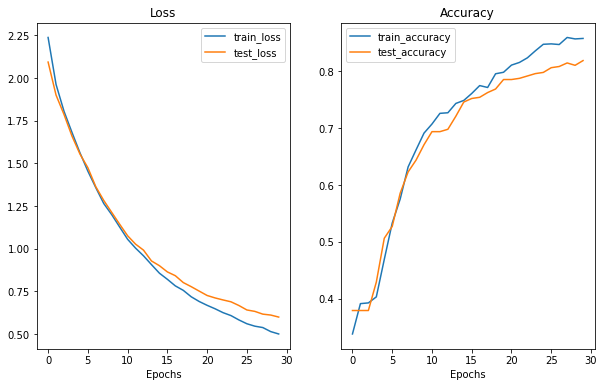

In [32]:
def plot_summary(results, epochs):
  plt.figure(figsize = (10, 6))
  # Plot loss
  epochs = range(epochs)
  plt.subplot(1, 2, 1)
  plt.plot(epochs, results['train_loss'], label="train_loss")
  plt.plot(epochs, results['test_loss'], label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

# Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, results['train_acc'], label="train_accuracy")
  plt.plot(epochs, results['test_acc'], label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


plot_summary(results, 30)

In [61]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np


response = requests.get('https://1.bp.blogspot.com/-xNalstgzm6U/Vs9DdF6vuCI/AAAAAAAFcrc/WD55wjTjlP0/s1600/Francisco%2BGoya%2BWay%2Bof%2BFlying.jpg')
img = Image.open(BytesIO(response.content))



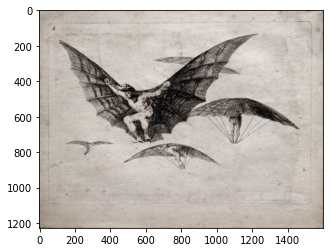

In [62]:
plt.imshow(img)

Text(0.5, 1.0, 'Artist Predicted - Francisco_Goya')

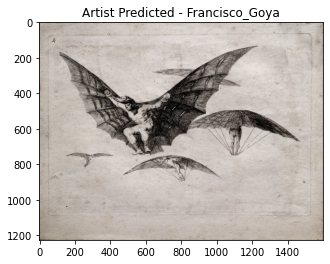

In [63]:
transformed_image = data_transform(img)
transformed_image = transformed_image.to(device)
predict_logit = model1(transformed_image.unsqueeze(dim = 0))
predict_artist = class_names[torch.argmax(torch.softmax(predict_logit, dim = 1), dim = 1)[0]]
plt.imshow(img)
plt.title(f'Artist Predicted - {predict_artist}')